# Book Recommendation System

## Content

1. About Dataset
2. Libraries and Utilities
3. Preprocessing
4. Item-Based Collaborative Filtering
5. Content-Based Collaborative Filtering using *Title, Author, Publisher, Category* as features
6. Content-Based Collaborative Filtering using *Summary* as a feature
7. Custom Recommender
8. Comparison of All Recommenders

# About Dataset

Contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books.

# Libraries and Utilities

In [ ]:
import os
import re
import nltk
import requests
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
nltk.download("stopwords")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image
warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load and Check Data

In [ ]:
books = pd.read_csv('/kaggle/input/bookcrossing-dataset/Books Data with Category Language and Summary/Preprocessed_data.csv')
books.head(3)

# Preprocessing

In [ ]:
df = books.copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.drop(columns = ['Unnamed: 0','location','isbn',
                   'img_s','img_m','city','age',
                   'state','Language','country',
                   'year_of_publication'],axis=1,inplace = True) #remove useless cols

df.drop(index=df[df['Category'] == '9'].index, inplace=True) #remove 9 in category

df.drop(index=df[df['rating'] == 0].index, inplace=True) #remove 0 in rating

df['Category'] = df['Category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())

df.head(2)

# Item-Based Collaborative Filtering

In [ ]:
def item_based_recommender(book_title):
    
    book_title = str(book_title)
    if book_title in df['book_title'].values:
    
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts['book_title'] <= 180].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            user_book_df = common_books.pivot_table(index=['user_id'],
                                                    columns=['book_title'],
                                                    values='rating')
        
            book = user_book_df[book_title]
            recom_data = pd.DataFrame(user_book_df.corrwith(book). \
                                      sort_values(ascending=False)).reset_index(drop=False)
            
            if book_title in [book for book in recom_data['book_title']]:
                recom_data = recom_data.drop(recom_data[recom_data['book_title'] == book_title].index[0])
                
            low_rating = []
            for i in recom_data['book_title']:
                if df[df['book_title'] == i]['rating'].mean() < 5:
                    low_rating.append(i)
                    
            if recom_data.shape[0] - len(low_rating) > 5:
                recom_data = recom_data[~recom_data['book_title'].isin(low_rating)]
            
            recom_data = recom_data[0:5]    
            recom_data.columns = ['book_title','corr']
            
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', size = 22)
            for i in range(len(recom_data['book_title'].tolist())):
        
                url = books.loc[books['book_title'] == recom_data['book_title'].tolist()[i],'img_l'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == recom_data['book_title'].tolist()[i]]['rating'].mean(),1)),
                             y=-0.18,
                                 color="red",
                                 fontsize=18)
                fig.show()
    else:
        print('Cant find book in dataset, please check spelling')

In [ ]:
item_based_recommender('Fahrenheit 451')

In [ ]:
item_based_recommender('The Street Lawyer')

In [ ]:
item_based_recommender('Divine Secrets of the Ya-Ya Sisterhood: A Novel')

# Content-Based Collaborative Filtering

## Title, Author, Publisher, Category

In [ ]:
def content_based_recommender(book_title):
    
    book_title = str(book_title)
    if book_title in df['book_title'].values:
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts['book_title'] <= 100].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            target_cols = ['book_title','book_author','publisher','Category']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],
                                      reverse=True)[1:6]
            
            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
            
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', size = 22)
            for i in range(len(books)):
        
                url = common_books.loc[common_books['book_title'] == books[i],'img_l'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == books[i]]['rating'].mean(),1)),
                             y=-0.18,
                                 color="red",
                                 fontsize=18)
                fig.show()
                     
    else:
        
        print('Cant find book in dataset, please check spelling')

In [ ]:
content_based_recommender('The Testament')

In [ ]:
content_based_recommender('1st to Die: A Novel')

In [ ]:
content_based_recommender('Harry Potter and the Order of the Phoenix (Book 5)')

## Summary

In [ ]:
def content_based_recommender2(book_title):
    
    book_title = str(book_title)
    if book_title in df['book_title'].values:
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts['book_title'] <= 100].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            
            summary_filtered = []
            for i in common_books['Summary']:
                
                i = re.sub("[^a-zA-Z]"," ",i).lower()
                i = nltk.word_tokenize(i)
                i = [word for word in i if not word in set(stopwords.words("english"))]
                i = " ".join(i)
                summary_filtered.append(i)
            
            common_books['Summary'] = summary_filtered   
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['Summary'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],reverse=True)[1:6]
            
            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
            
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', size = 22)
            for i in range(len(books)):
        
                url = common_books.loc[common_books['book_title'] == books[i],'img_l'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == books[i]]['rating'].mean(),1)),
                             y=-0.18,
                                 color="red",
                                 fontsize=18)
                fig.show()
                     
    else:
        
        print('Cant find book in dataset, please check spelling')

In [ ]:
content_based_recommender2('To Kill a Mockingbird')

In [ ]:
content_based_recommender2('A Walk to Remember')

In [ ]:
content_based_recommender2('A Painted House')

# Custom Recommender

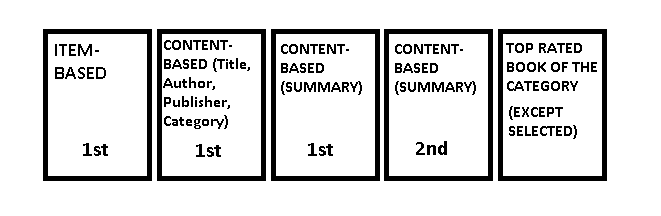

In [ ]:
def custom_recommender(book_title):
    
    #ITEM-BASED
    book_title = str(book_title)
    if book_title in df['book_title'].values:
    
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts['book_title'] <= 180].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            user_book_df = common_books.pivot_table(index=['user_id'],
                                                    columns=['book_title'], values='rating')
        
            book = user_book_df[book_title]  
            recom_data = pd.DataFrame(user_book_df.corrwith(book). \
                                      sort_values(ascending=False)).reset_index(drop=False)
            
            if book_title in [book for book in recom_data['book_title']]:
                recom_data = recom_data.drop(recom_data[recom_data['book_title'] == book_title].index[0])
                
            low_rating = []
            for i in recom_data['book_title']:
                if df[df['book_title'] == i]['rating'].mean() < 5:
                    low_rating.append(i)
                    
            if recom_data.shape[0] - len(low_rating) > 5:
                recom_data = recom_data[~recom_data['book_title'].isin(low_rating)]
            
            recom_data = recom_data[0:1]    
            recom_data.columns = ['book_title','corr']
            recommended_books = []
            for i in recom_data['book_title']:
                recommended_books.append(i)
                
            df_new = df[~df['book_title'].isin(recommended_books)]
            
            #CONTENT-BASED (Title, Author, Publisher, Category)
            rating_counts = pd.DataFrame(df_new['book_title'].value_counts())
        
            rare_books = rating_counts[rating_counts['book_title'] <= 100].index
    
            common_books = df_new[~df_new['book_title'].isin(rare_books)]
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]   
            target_cols = ['book_title','book_author','publisher','Category']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],reverse=True)[1:2]
            
            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
                
            for i in books:
                recommended_books.append(i)
            
            df_new = df_new[~df_new['book_title'].isin(recommended_books)]
            
            #CONTENT-BASED (SUMMARY)
            rating_counts = pd.DataFrame(df_new['book_title'].value_counts())
            rare_books = rating_counts[rating_counts['book_title'] <= 100].index
            common_books = df_new[~df_new['book_title'].isin(rare_books)]
            
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            
            summary_filtered = []
            for i in common_books['Summary']:
                
                i = re.sub("[^a-zA-Z]"," ",i).lower()
                i = nltk.word_tokenize(i)
                i = [word for word in i if not word in set(stopwords.words("english"))]
                i = " ".join(i)
                summary_filtered.append(i)
            
            common_books['Summary'] = summary_filtered
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['Summary'])
            cosine_sim = cosine_similarity(count_matrix) 
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books2 = sorted(sim_books,key=lambda x:x[1],reverse=True)[1:4]
            sorted_sim_books = sorted_sim_books2[:2]
            summary_books = []
            for i in range(len(sorted_sim_books)):
                summary_books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
                
            for i in summary_books:
                recommended_books.append(i)
                
            df_new = df_new[~df_new['book_title'].isin(recommended_books)]
            
            #TOP RATED OF CATEGORY
            category = common_books[common_books['book_title'] == book_title]['Category'].values[0]
            top_rated = common_books[common_books['Category'] == category].groupby('book_title').agg({'rating':'mean'}).reset_index()
            
            if top_rated.shape[0] == 1:
                recommended_books.append(common_books[common_books['index'] == sorted_sim_books2[2][0]]['book_title'].item())
                
            else:
                top_rated.drop(top_rated[top_rated['book_title'] == book_title].index[0],inplace=True)
                top_rated = top_rated.sort_values('rating',ascending=False).iloc[:1]['book_title'].values[0]
                recommended_books.append(top_rated)
                
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', size = 22)
            for i in range(len(recommended_books)):
        
                url = df.loc[df['book_title'] == recommended_books[i],'img_l'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == recommended_books[i]]['rating'].mean(),1)),
                             y=-0.18,
                                 color="red",
                                 fontsize=18)
                fig.show()     

    else:
        print('Cant find book in dataset, please check spelling')

In [ ]:
custom_recommender('The Summons')

In [ ]:
custom_recommender('Snow Falling on Cedars')

In [ ]:
custom_recommender("Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson")

# Comparison of All Recommenders

In [ ]:
item_based_recommender('Harry Potter and the Order of the Phoenix (Book 5)')

In [ ]:
content_based_recommender('Harry Potter and the Order of the Phoenix (Book 5)')

In [ ]:
content_based_recommender2('Harry Potter and the Order of the Phoenix (Book 5)')

In [ ]:
custom_recommender('Harry Potter and the Order of the Phoenix (Book 5)')

**Let's try another book**

In [ ]:
item_based_recommender('Girl with a Pearl Earring')

In [ ]:
content_based_recommender('Girl with a Pearl Earring')

In [ ]:
content_based_recommender2('Girl with a Pearl Earring')

In [ ]:
custom_recommender('Girl with a Pearl Earring')

**If you liked this notebook, please upvote** 😊

**If you have any suggestions or questions, feel free to comment!**

**Best Wishes!**